In [1]:
# 

applying deep learning on twitter’s sentiment analysis

*   Prepare Data - download and prepare 21 millions tweets dat
*   Perform Pre-processing - use NLP techniques to pre-process the tweets

*   Discover Important Words - use tf-idf and counting to find important words
*   Convert Word Representation - download word2vec and apply to the important word

*   Train Model - use keras to build and train a deep neural network model

*   Evaluate Model - measure the accuracy of the predictive model, and suggest further improvements


IMPORTING DATASET


In [2]:
!pip install contractions
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import casual

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

     |████████████████████████████████| 245kB 4.3MB/s 
     |████████████████████████████████| 317kB 6.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81701 sha256=77d89fd47b6e13ebcb72334f893d87d4125c76c68bb360497f358f017ccf949a
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [3]:
#being able to read csv stored in google drive 
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Reading the dataset with no columns titles and with latin encoding 
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/tweetsENdates.csv')
df.sample(3)


,date,timestamp,text,lang
4618557,2018-11-29,2018-11-29 10:06:36+00,Same question! What will you do when the marke...,en
14536019,2019-08-17,2019-08-17 15:16:12+00,I have $1 in a bitcoin. What that mean?,NaN
18375954,2019-10-07,2019-10-07 17:54:46+00,@esiattorney LeoAW 100 sats were just sent to ...,en


In [5]:
# Checking if there is any missing value and datatype 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21540060 entries, 0 to 21540059
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   date       object
 1   timestamp  object
 2   text       object
 3   lang       object
dtypes: object(4)
memory usage: 657.4+ MB


In [6]:

# checking for null values, if any
df.isnull().sum()

date          5589941
timestamp      748197
text          6010458
lang         14459288
dtype: int64

In [7]:
#ditching all row when text is null, as need text for analysis
df.dropna(how='any', inplace=True)

In [8]:
df.sample(3)

,date,timestamp,text,lang
10510309,2019-07-05,2019-07-05 07:14:13+00,it is now your own time to start mining bitcoi...,en
12066990,2019-07-18,2019-07-18 22:23:09+00,"A new privacy coin, Ycash, will be created in ...",en
9119354,2019-06-22,2019-06-22 17:00:09+00,"Price Update: 1 #Bitcoin = $10,913.86 📈 \n\n#c...",en


In [9]:
#setting column width wider to read text 
pd.set_option('display.max_colwidth',700)

In [10]:
# Ommiting every column except for the text and the date, as we won't need any of the other information
df = df[['date','text']]
df.sample(3)

,date,text
7692315,2019-06-08,"Top 5 #cryptocurrencies \n Alert Time: 2019-06-09 00:40:02\n#Bitcoin: $7,919.457\n#Ethereum: $244.837\n#XRP: $0.413\n#Litecoin: $117.988\n#BitcoinCash: $396.099\n#instaeth #instaairdrop #crypto #cryptocurrencymarket #bittrex\n\nhttps://t.co/rdEr8N5koT\r"
14031859,2019-08-10,"Top 5 #cryptocurrencies \n Alert Time: 2019-08-10 11:00:31\n#Bitcoin: $11,823.83309\n#Ethereum: $211.77519\n#XRP: $0.30210\n#BitcoinCash: $319.29555\n#Litecoin: $85.10328\n#cryptocurrencymarket #pumpanddump #tothemoon #shill\n\nhttps://t.co/EmfFKaRVKs\r"
5854162,2019-05-16,Buy/Sell BTC changes with up to 100x Leverage at PrimeXBT! 🤑🤩\n\nReceive money even when BTC is falling! 📉\n\n➡️ https://t.co/tbahKgpCZF https://t.co/AIoes2BHFr\r


1 - Is dataset unbalanced ? do we need to split according to a criteria and take sample of those? splitting, skimming and concatening?

1a/ CLEANING DATE

In [11]:
#Create split by dates 
df.date.dtypes

dtype('O')

In [12]:

df.date = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df.sample(3)

,date,text
2490601,2018-08-01,"thank you , I am pretty bad an interviews, but tried my best\r"
4928858,2019-01-23,New post in BitcoinTrade: http://Blockchain.com Wallet Confirms ‘Limited Support’ for Bitcoin SV http://Blockchain.com Wallet Confirms ‘Limited Support’ for Bitcoin SV\n<img src=\r
8701926,2019-06-17,"Bitcoin Maintains $9,200 Level Ahead of Facebook's GlobalCoin Reveal https://t.co/eHYRDZ5k5t\r"


1b/ Checking if tweets DO PROMOTE with subscribe

In [13]:
#can we get counts of tweets that contain Follow us or subscribe?
(df['text'].str.contains('subscribe|follow')).sum()

93360

In [14]:
#checking the few tweets that do NOT contain follow or subscribe
(~df['text'].str.contains('subscribe|follow')).sum()

6987412

1c/ CHecking if tweets can be CLASSIFIED by TAGS


In [15]:
#checking balance of tweets having # or not
df['text'].str.contains('#').sum()

3817736

SOME VISUALIZATION

In [16]:
df = df.sort_values(by='date')

In [17]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [18]:
df.groupby('year').sum()

,month,day
year,,
2017,2220966,2926514
2018,3063102,5396700
2019,48081169,102710850


In [19]:
df.year.value_counts().loc[lambda x : x>10000] 

2019    6332376
2018     508793
2017     239603
Name: year, dtype: int64

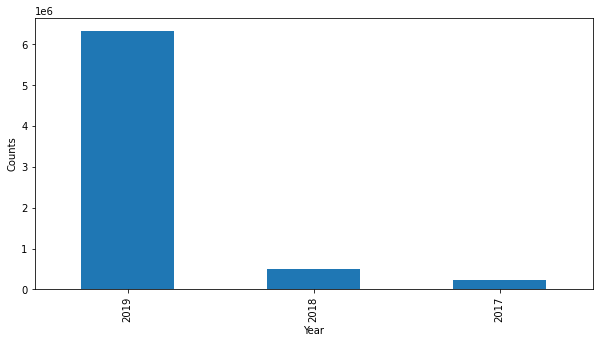

In [20]:
# Visualization of news article count per year

plt.figure(figsize=(10,5))
plt.xlabel("Year")
plt.ylabel("Counts")

df.year.value_counts().plot(kind='bar')
plt.show()

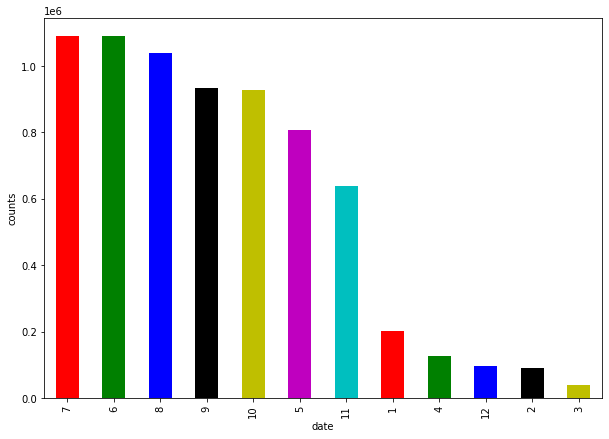

In [21]:
# Visualization of news publications names and article count in the dataset

import matplotlib.pyplot as plt

color_list = list('rgbkymc')  #red, green, blue, black, etc.
plt.figure(figsize=(10,7))

plt.xlabel("date")
plt.ylabel("counts")

df.month.value_counts().plot(kind='bar', color=color_list)

2 - skimming tokenize, lemmatize

2a / PART OF SPEECH CLEANING

In [22]:
#expanding contractions
try:
  df['text1'] = df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
except:
  df['text1'] = df['text']




In [23]:
# #joining back the list of items into one string

# df['text2'] = [' '.join(map(str, l)) for l in df['text1']]
# df.sample(3, random_state = 3)

In [24]:
#extracting the URL to clean what can be analysed
def get_url(x):
  urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)
  
  if len(urls)==0:
    return ' '
  else:
    return urls

In [25]:
df['url'] = df['text1'].apply(lambda x: get_url(x) )
df['url'] = [' '.join(map(str, l)) for l in df['url']]
df.sample(3)

,date,text,year,month,day,text1,url
11450724,2019-07-14,"@BoilingPointLTC @jonnylitecoin @FlexaHQ @dunkindonuts @davidericc @johnkim77 Did the same yesterday in Athens, AL. The cashier had NO IDEA.... The woman behind me look at me with amazement when i told her what had just happened.... #oneatatime #BTC #LTC #TRANSITION\r",2019,7,14,"@BoilingPointLTC @jonnylitecoin @FlexaHQ @dunkindonuts @davidericc @johnkim77 Did the same yesterday in Athens, AL. The cashier had NO IDEA.... The woman behind me look at me with amazement when i told her what had just happened.... #oneatatime #BTC #LTC #TRANSITION\r",
18120018,2019-10-02,Character is how you treat those who can do nothing for you\n#WednesdayWisdom #WednesdayThoughts #bitcoin #Crypto https://t.co/WVfCpUU9qb\r,2019,10,2,Character is how you treat those who can do nothing for you\n#WednesdayWisdom #WednesdayThoughts #bitcoin #Crypto https://t.co/WVfCpUU9qb\r,https://t.co/WVfCpUU9qb
1991376,2018-04-06,"RT hackapreneur: SEC Clayton: Whether a token qualifies as a security could also change as the industry evolves, he said, adding:\n\n""Just because it's a security today doesn't mean it'll be a security tomorrow, and vice-versa.""\n\n#sec #bitcoin #blockchain …https://twitter.com/coindesk/status/981992055546241029 …\r",2018,4,6,"RT hackapreneur: SEC Clayton: Whether a token qualifies as a security could also change as the industry evolves, he said, adding:\n\n""Just because it's a security today doesn't mean it'll be a security tomorrow, and vice-versa.""\n\n#sec #bitcoin #blockchain …https://twitter.com/coindesk/status/981992055546241029 …\r",https://twitter.com/coindesk/status/981992055546241029


In [26]:
#extracting the Tags to be able to clearer
def tag(x):
  hashtag = set(part[1:] for part in x.split() if part.startswith('#'))
  
  if len(hashtag)==0:
    return ' '
  else:
    return hashtag

df['tags'] = df['text1'].apply(lambda x: tag(x) )
df['tags'] = [' '.join(map(str, l)) for l in df['tags']]
df.sample(3)

,date,text,year,month,day,text1,url,tags
14351095,2019-08-14,"Blockchain 2015 on Blockchain Radio - John McAfee Flees The US, Wyoming Opens Up For Cryptocurrency Companies &amp; More Bitcoin Cash News\r",2019,8,14,"Blockchain 2015 on Blockchain Radio - John McAfee Flees The US, Wyoming Opens Up For Cryptocurrency Companies &amp; More Bitcoin Cash News\r",,
11188600,2019-07-11,DOCK/BTC touched 0.00000120 ✅ Target 3 booked just in 1 day\n❤ Profit 27.7% . All target achieved remarkably\nmore profit for you from all free signal: https://t.co/VAwyyr9smd\n#binancesignal #cryptosignal #bitcoin #crypto #DOCK\r,2019,7,11,DOCK/BTC touched 0.00000120 ✅ Target 3 booked just in 1 day\n❤ Profit 27.7% . All target achieved remarkably\nmore profit for you from all free signal: https://t.co/VAwyyr9smd\n#binancesignal #cryptosignal #bitcoin #crypto #DOCK\r,https://t.co/VAwyyr9smd,binancesignal crypto DOCK bitcoin cryptosignal
18969558,2019-10-16,BTC\n\n来ました。\n\n直近高値更新。\n\nここで一度も跳ね返されずに天井を破れたのはいい流れです。\n\nというのもここは前回高値7/26から半値ラインであり、日足レベルでも大きなレジスタンスが通る位置なのですが、その割に上値の重さを感じさせない値動きです。\n\nこれにより日足の雲に食い込みました。 https://t.co/xS2tRM0buh\r,2019,10,16,BTC\n\n来ました。\n\n直近高値更新。\n\nここで一度も跳ね返されずに天井を破れたのはいい流れです。\n\nというのもここは前回高値7/26から半値ラインであり、日足レベルでも大きなレジスタンスが通る位置なのですが、その割に上値の重さを感じさせない値動きです。\n\nこれにより日足の雲に食い込みました。 https://t.co/xS2tRM0buh\r,https://t.co/xS2tRM0buh,


In [27]:
#extracting the follow or subscribe info on a specific column
def prom(x):
  promoting = re.findall('subscribe | follow | promo', x)
  
  if len(promoting)==0:
    return ' '
  else:
    return promoting

df['promote'] = df['text1'].apply(lambda x: prom(x) )
df['promote'] = [' '.join(map(str, l)) for l in df['promote']]
df.sample(3)

,date,text,year,month,day,text1,url,tags,promote
17182329,2019-09-19,Explosive Mining Growth Indicates High Confidence in Bitcoin\n\nhttps://t.co/ceCTvxPUL9\r,2019,9,19,Explosive Mining Growth Indicates High Confidence in Bitcoin\n\nhttps://t.co/ceCTvxPUL9\r,https://t.co/ceCTvxPUL9,,
8281272,2019-06-14,4 Notes on Bittrex Delisting Dozens of Tokens for US Clients\n➡️https://t.co/o83eynoxto\n🗺️\n▶️https://t.co/vdnO18c8ZC\n#newsoftheweek #Bitcoin #blockchain #crypto https://t.co/BbTRlIydrA\r,2019,6,14,4 Notes on Bittrex Delisting Dozens of Tokens for US Clients\n➡️https://t.co/o83eynoxto\n🗺️\n▶️https://t.co/vdnO18c8ZC\n#newsoftheweek #Bitcoin #blockchain #crypto https://t.co/BbTRlIydrA\r,https://t.co/o83eynoxto https://t.co/vdnO18c8ZC https://t.co/BbTRlIydrA,newsoftheweek Bitcoin blockchain crypto,
6174817,2019-05-20,EVET..\n\n#YKBNK\n\n1.93 AL\n\n#DOLAR\n#DolarTL\n#bist\n#bist100 \n#usdtry\n#USDTRY\n#XU100 \n#𝒷𝑒𝓁𝑒𝓃𝓈𝒶𝓎 2012\n#doge #dogeusd\n#btc #btcusd\nYTD\r,2019,5,20,EVET..\n\n#YKBNK\n\n1.93 AL\n\n#DOLAR\n#DolarTL\n#bist\n#bist100 \n#usdtry\n#USDTRY\n#XU100 \n#𝒷𝑒𝓁𝑒𝓃𝓈𝒶𝓎 2012\n#doge #dogeusd\n#btc #btcusd\nYTD\r,,dogeusd DOLAR bist usdtry USDTRY YKBNK 𝒷𝑒𝓁𝑒𝓃𝓈𝒶𝓎 bist100 btcusd doge XU100 DolarTL btc,


2 - TOKENIZE

In [28]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import regex as re
import contractions
# Install spaCy (run in terminal/prompt)
import sys


In [29]:
#!!!!! CLEANING PROCESS, TAKES 38-40 minutes...
#this command needs to be pushed before tokenization
# >>>> COULD ADD LINE FOR AUTOCORRECT ET REMPLACER LES EMOJI PAR CE QU ILS MEAN

import nltk
nltk.download('stopwords')

def process(text):

    #Convert to lower case
    text = text.lower()
    #Convert www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    #Remove @username 
    text = re.sub('@[^\s]+',' ',text)
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    #trim
    text = text.strip('\'"')

    #remove punctuation
    for punctuation in string.punctuation: 
        text = text.replace(punctuation, ' ') 

    #words only
    text = ''.join([i for i in text if not i.isdigit()])

    #tokenize
    words = nltk.tokenize.casual_tokenize(text)

    #Remove stopwords
    stops = set(stopwords.words('english'))
    clean = [w for w in words if not w in stops]

    return ' '.join(clean)

df['clean'] = df['text1'].apply(lambda text: process(text))

df.sample(3, random_state = 3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,date,text,year,month,day,text1,url,tags,promote,clean
8801326,2019-06-18,"What bitcoiners may soon say, “Long Bitcoin, Short bankers and the USD thru Libracoin” @crypto_birb @CryptoAmb @CryptoInfoNEM @lovesNem\r",2019,6,18,"What bitcoiners may soon say, “Long Bitcoin, Short bankers and the USD thru Libracoin” @crypto_birb @CryptoAmb @CryptoInfoNEM @lovesNem\r",,,,bitcoiners may soon say “ long bitcoin short bankers usd thru libracoin ”
78569,2017-02-28,$1209.80 #bitfinex;\n$1209.01 #GDAX;\n$1203.00 #bitstamp;\n$1185.00 #btce;\n$1208.90 #gemini;\n\n#bitcoin news: http://bit.ly/1VI6Yse \r,2017,2,28,$1209.80 #bitfinex;\n$1209.01 #GDAX;\n$1203.00 #bitstamp;\n$1185.00 #btce;\n$1208.90 #gemini;\n\n#bitcoin news: http://bit.ly/1VI6Yse \r,http://bit.ly/1VI6Yse,GDAX; gemini; btce; bitcoin bitstamp; bitfinex;,,bitfinex gdax bitstamp btce gemini bitcoin news
1528305,2017-12-09,"I just published “Realtors, get armed with Bitcoin and Blockchain knowledge” https://medium.com/p/realtors-get-armed-with-bitcoin-and-blockchain-knowledge-259aa2640a6a …\r",2017,12,9,"I just published “Realtors, get armed with Bitcoin and Blockchain knowledge” https://medium.com/p/realtors-get-armed-with-bitcoin-and-blockchain-knowledge-259aa2640a6a …\r",https://medium.com/p/realtors-get-armed-with-bitcoin-and-blockchain-knowledge-259aa2640a6a,,,published “ realtors get armed bitcoin blockchain knowledge ” …


In [30]:
df = df.reset_index()
df = df[['date', 'year','clean','url','tags','promote']]

In [31]:
#export to new CSV as it crashes otherwise
df.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP/tweetsClean.csv')

In [32]:
#  to load your pickle file to a new notebook and use the dataframe:
# with open("/content/drive/MyDrive/Colab Notebooks/NLP/tweetsClean.pkl", "rb") as file:
#         df = pickle.load(file)

no need to stem or lemmatize, the words are so small, that it ends up just letters

STOP VISU - TESTING WORD CLOUD WITH WHAT WE HAVE

In [33]:
!pip install wordcloud

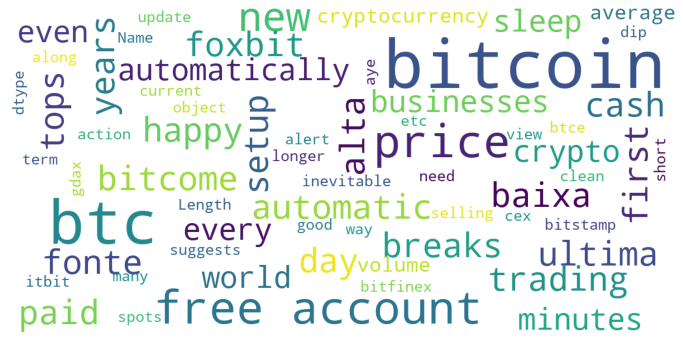

In [34]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# Light pre-processing
stopwords = set(STOPWORDS)
# Define Word Cloud generation function
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=1000,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
wordworld_text = df['clean']
show_wordcloud (wordworld_text)

Visualizing N-grams of vectors

In [35]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

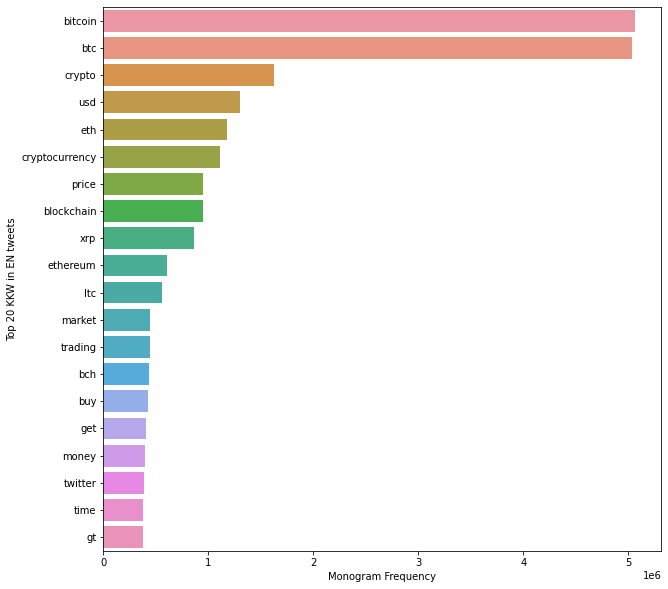

In [36]:
#Mono-grams - takes a while - 10 minutes

def plot_top_ngrams_barchart(text, n=1):

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel("Monogram Frequency")
    plt.ylabel("Top 20 KKW in EN tweets")
    sns.barplot(x=y,y=x)


plot_top_ngrams_barchart(df['clean'],1)


In [37]:
#Bi-grams - takes a while - 5 minutes

def plot_top_ngrams_barchart(text, n=2):

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel("Bi-gram Frequency")
    plt.ylabel("Top 20 KW in EN tweets")
    sns.barplot(x=y,y=x)


plot_top_ngrams_barchart(df['clean'],2)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-9f01e9f53d7b>", line 26, in <module>
    plot_top_ngrams_barchart(df['clean'],2)
  File "<ipython-input-37-9f01e9f53d7b>", line 18, in plot_top_ngrams_barchart
    top_n_bigrams=_get_top_ngram(text,n)[:20]
  File "<ipython-input-37-9f01e9f53d7b>", line 10, in _get_top_ngram
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py", line 1186, in fit
    self.fit_transform(raw_documents)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py", line 1220, in fit_transform
    self.fixed_vocabulary_)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py", line 1143, in _count_vocab
    values.extend(feature_counter.values())
KeyboardInte

KeyboardInterrupt: ignored

STOP HERE AND GO TO NOTEBOOK NLP3


EXTRACTING FEATURES FROM CLEANED TWEETS 10 min

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

In [ ]:
#bag of words = OPTION A
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean'])
bow.shape

In [ ]:
#TfIdf = OPTION B 

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['clean'])
tfidf.shape

Word 2 Vec : KeyError: "word 'eth vs btc relative vol spread interesting junction esp given btc dominance v alt season sentiment participants cryptooptions releativevalue' not in vocabulary"
or  "word 'bizpaye trading platform system unique never done history modern day trade exchanges bizpaye marketplace hodl bartercredit crypto cryptotrading btc onlineshopping merchants ecommerce bb bc retail' not in vocabulary"

PREPARE FOR MODELING






---



DEFINING X and Y

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
#1- vectoring data
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector


In [ ]:
#2- CREATING a FAKE Y
#ate 11 dec 2017
#ate 10 dec 2018
#ate end

def senti(x):
  if x < 2018:
    return 'BULL'
  elif x > 2018:
    return 'BULL2'
  else:
    return 'BEAR'

df['sent'] = df['year'].apply(lambda x: senti(x) )
df.tail(3)

In [ ]:
df['sent'].value_counts()

LAUNCHING MODEL BASES after 1 hour of running



In [ ]:
#splitting - takes 5 minutes
tf_vector = get_feature_vector(np.array(df['clean']).ravel())
X = tf_vector.transform(np.array(df['clean']).ravel())
y = np.array(df['sent']).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)


In [ ]:
# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))

In [ ]:
# Training Logistics Regression model - reducing to solver libelinear cause lbfgs or newton_cg are to expansive and take 5 good minutes
LR_model = LogisticRegression(solver='liblinear')
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

In [ ]:
#SVM - takes 15 min
from sklearn import svm
svc = svm.SVC().fit(X_train, y_train)
y_predict_svm =  svc.predict(X_test)
print(accuracy_score(y_test, y_predict_svm))

In [ ]:
#Training Random Forest 

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train, y_train) 
y_predict_rf = rf.predict(X_test)
print(accuracy_score(y_test, y_predict_rf))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_predict_rf))
print(classification_report(y_test,y_predict_rf))
print(accuracy_score(y_test, y_predict_rf))

In [ ]:
# TRaining XGB
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(X_train, y_train)
y_predict_xgb = xgb.predict(X_test)
print(accuracy_score(yvalid, y_predict_xgb))

GO FURTHER
score pour chaque column / mot - lesquels ont ete le plus utilise pour predire
carac du model ou PCA (mix de col qui marchent le mieux, qu est ce qui max la variance et apporte le plus d info) => qu est ce qui a ete utilise le plus par le modele

ajouter d autres colonnes avec  ou essayer d autres modeles comme RF ou classifier plus finement les Y ou faire un clustering non supervise, si pas de Y, patterns par time, plusieurs clusters, can it work

FINE TUNING







PCA 